# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
START = 2000
END = 2018

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2925 entries, A to UFPI
dtypes: float64(2925)
memory usage: 105.1 MB


In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, A to UFPI
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2200 non-null   float64
 1   ipoyear    982 non-null    float64
 2   sector     2167 non-null   object 
dtypes: float64(2), object(1)
memory usage: 68.9+ KB


In [12]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2205 entries, A to UFPI
dtypes: float64(2205)
memory usage: 79.2 MB


In [13]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [14]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [15]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2205 entries, A to UFPI
dtypes: float64(2205)
memory usage: 3.7 MB


In [16]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 365449 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('UFPI', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   365449 non-null  float64
 1   return_2m   365449 non-null  float64
 2   return_3m   365449 non-null  float64
 3   return_6m   365449 non-null  float64
 4   return_9m   365449 non-null  float64
 5   return_12m  365449 non-null  float64
dtypes: float64(6)
memory usage: 18.2+ MB


In [17]:
monthly_prices.pct_change().stack()

date        ticker
2000-02-29  A         0.569724
            AAN       0.036730
            AAON      0.070263
            AAPL      0.104771
            ABAX     -0.007631
                        ...   
2018-03-31  UEC      -0.030769
            UEIC      0.021212
            UFCS      0.055081
            UFI       0.030286
            UFPI      0.000000
Length: 389641, dtype: float64

In [18]:
monthly_prices.pct_change().stack().pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))

date        ticker
2000-02-29  A         0.430645
            AAN       0.036730
            AAON      0.070263
            AAPL      0.104771
            ABAX     -0.007631
                        ...   
2018-03-31  UEC      -0.030769
            UEIC      0.021212
            UFCS      0.055081
            UFI       0.030286
            UFPI      0.000000
Length: 389641, dtype: float64

## Drop stocks with less than 10 yrs of returns

In [19]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 330091 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('UFPI', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   330091 non-null  float64
 1   return_2m   330091 non-null  float64
 2   return_3m   330091 non-null  float64
 3   return_6m   330091 non-null  float64
 4   return_9m   330091 non-null  float64
 5   return_12m  330091 non-null  float64
dtypes: float64(6)
memory usage: 16.5+ MB


In [20]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,330091.000000,330091.000000,330091.000000,330091.000000,330091.000000,330091.000000
mean,0.012270,0.009219,0.008178,0.007011,0.006535,0.006280
std,0.114518,0.081372,0.066780,0.048566,0.039948,0.034810
min,-0.329697,-0.255402,-0.214786,-0.161878,-0.131699,-0.113675
25%,-0.046816,-0.030985,-0.024203,-0.015098,-0.011356,-0.009205
50%,0.009455,0.009756,0.009781,0.009346,0.008981,0.008712
75%,0.066334,0.049522,0.042263,0.032101,0.027289,0.024712
max,0.430645,0.281953,0.222135,0.154542,0.124422,0.105986


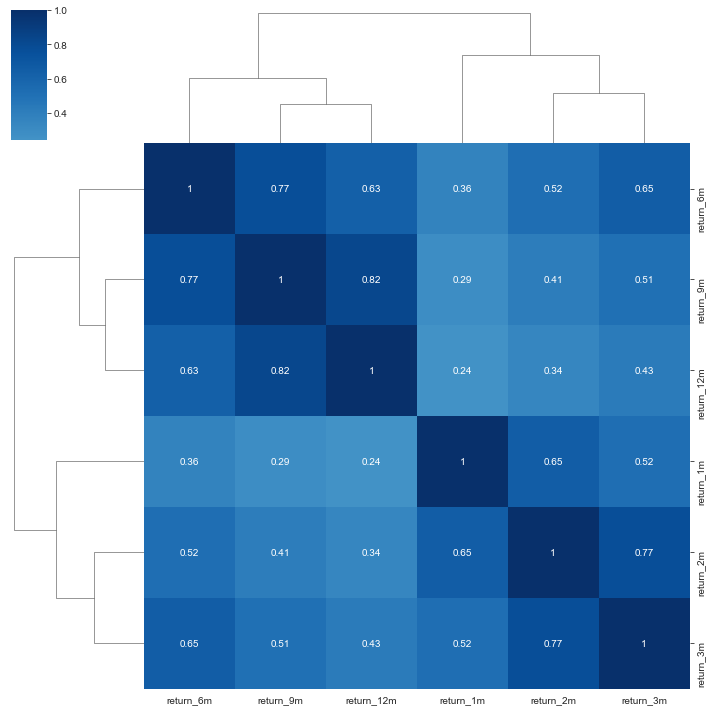

In [21]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [22]:
data.index.get_level_values('ticker').nunique()

1683

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

In [ ]:
factor_data

In [ ]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

In [ ]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [ ]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

In [ ]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [ ]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

### Impute mean for missing factor betas

In [ ]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [ ]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [ ]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [ ]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [ ]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [ ]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

In [ ]:
data.info()

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [ ]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [ ]:
stocks.info()

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [ ]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

In [ ]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [ ]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [ ]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [ ]:
data.info()

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [ ]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()